# Gaussian Process Regression vs Linear Regression

This notebook compares Gaussian Process Regression (GPR) and Linear Regression for modeling data.

## Concepts

**Linear Regression:**
- Assumes a linear relationship between input $X$ and output $y$.
- Model: $y = X\beta + \epsilon$, with Gaussian noise $\epsilon$.

**Gaussian Process Regression:**
- Non-parametric, defines a distribution over functions.
- Uses a kernel to model similarity and smoothness.
- Model: $f(x) \sim \mathcal{GP}(m(x), k(x, x'))$, $y = f(x) + \epsilon$.
- Can capture nonlinear relationships and uncertainty.

## Example: Nonlinear Data
We generate data from a nonlinear function and compare the fits.

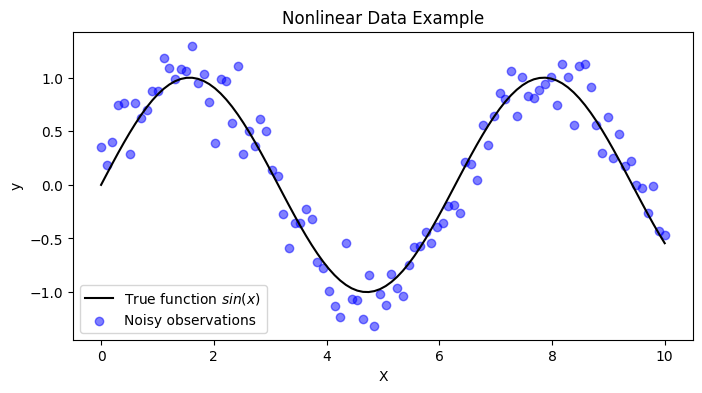

In [4]:
# Generate nonlinear data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(0)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y_true = np.sin(X).ravel()
y = y_true + np.random.normal(0, 0.2, X.shape[0])

# Plot true function and noisy observations
plt.figure(figsize=(8,4))
plt.plot(X, y_true, label='True function $sin(x)$', color='black')
plt.scatter(X, y, label='Noisy observations', color='blue', alpha=0.5)
plt.title('Nonlinear Data Example')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

## Linear Regression Fit
Fit a linear model to the nonlinear data.

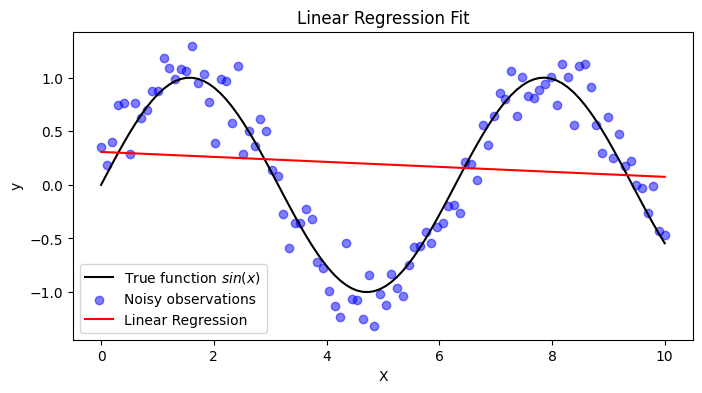

In [5]:
lr = LinearRegression()
lr.fit(X, y)
y_lr_pred = lr.predict(X)

plt.figure(figsize=(8,4))
plt.plot(X, y_true, label='True function $sin(x)$', color='black')
plt.scatter(X, y, label='Noisy observations', color='blue', alpha=0.5)
plt.plot(X, y_lr_pred, label='Linear Regression', color='red')
plt.title('Linear Regression Fit')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

## Gaussian Process Regression Fit
Fit a GP model with RBF kernel to the same data.

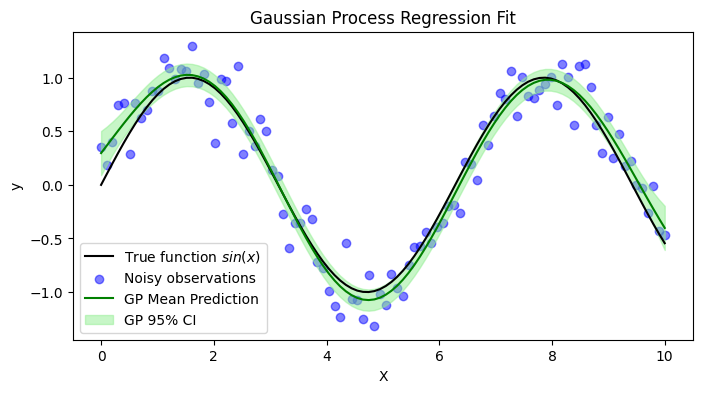

In [6]:
kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.2**2)
gpr.fit(X, y)
y_gp_pred, y_gp_std = gpr.predict(X, return_std=True)

plt.figure(figsize=(8,4))
plt.plot(X, y_true, label='True function $sin(x)$', color='black')
plt.scatter(X, y, label='Noisy observations', color='blue', alpha=0.5)
plt.plot(X, y_gp_pred, label='GP Mean Prediction', color='green')
plt.fill_between(X.squeeze(), y_gp_pred - 2*y_gp_std, y_gp_pred + 2*y_gp_std, color='lightgreen', alpha=0.5, label='GP 95% CI')
plt.title('Gaussian Process Regression Fit')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

## Comparison and Discussion

- **Linear Regression** cannot capture the nonlinear pattern, resulting in a poor fit.
- **Gaussian Process Regression** flexibly models the nonlinear function and provides uncertainty estimates.

GPR is more powerful for nonlinear regression tasks, while linear regression is suitable for simple, linear relationships.

### Appendix. Gaussian Process Regression: Mathematical Breakdown

**1. Kernel Function:**

The kernel $k(x, x')$ encodes similarity between points. Here we use:

- **ConstantKernel ($C$):** Sets the overall variance (vertical scale) of the function.
- **RBF Kernel ($\text{RBF}$):** Controls smoothness and how quickly correlation decays with distance. The RBF kernel is:

$$
k(x, x') = C \exp\left(-\frac{(x-x')^2}{2\ell^2}\right)
$$
where $\ell$ is the length scale.

**2. GP Prior:**

Before seeing data, the GP assumes:

$$
f(x) \sim \mathcal{GP}(0, k(x, x'))
$$

**3. GP Posterior Prediction:**

Given training data $(X, y)$ and test points $X_*$, the GP predicts:

$$
\begin{align*}
\mu_* &= K(X_*, X)[K(X, X) + \sigma_n^2 I]^{-1} y \\
\Sigma_* &= K(X_*, X_*) - K(X_*, X)[K(X, X) + \sigma_n^2 I]^{-1}K(X, X_*)
\end{align*}
$$
where $K$ is the kernel matrix and $\sigma_n^2$ is the noise variance.

**4. Uncertainty Quantification:**

- The GP provides a mean prediction $\mu_*$ and standard deviation $\sqrt{\text{diag}(\Sigma_*)}$ for each test point.
- The shaded region in the plot shows the 95% confidence interval: $\mu_* \pm 2\sigma_*$.

This allows GPR to not only fit nonlinear functions, but also express uncertainty about its predictions.

### When to Use Gaussian Process Regression

**Gaussian Process Regression (GPR) is most useful when:**

- You expect a smooth, possibly nonlinear relationship between input and output.
- You want to quantify uncertainty in predictions.
- The dataset is not extremely large (GPR scales poorly with sample size, typically up to a few thousand points).
- You do not want to specify a fixed parametric form for the function.

**Assumptions:**

- The underlying function is continuous and reasonably smooth (as encoded by the kernel).
- Observations are noisy but the noise is Gaussian.
- Inputs can be real-valued vectors; GPR is flexible for 1D or low-dimensional data.

**Typical use cases:**

- Regression tasks with complex, unknown functional forms.
- Bayesian optimization and active learning.
- Time series modeling (with appropriate kernels).
- Spatial data (e.g., geostatistics, kriging).

GPR is less suitable for very large datasets, high-dimensional inputs, or problems where the underlying function is highly discontinuous.

## Example: When Gaussian Process Regression Does Not Work Well

GPR can struggle with:
- Large datasets (computational cost)
- Highly discontinuous or non-smooth functions
- High-dimensional input spaces

Below, we show an example with a discontinuous step function.

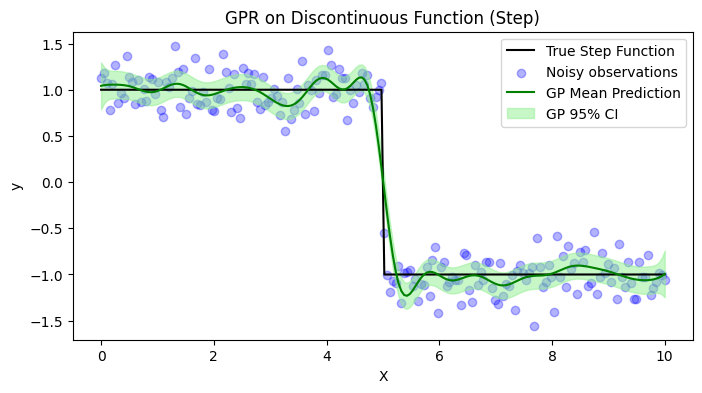

In [7]:
# Discontinuous function example
X_step = np.linspace(0, 10, 200).reshape(-1, 1)
y_step_true = np.where(X_step < 5, 1.0, -1.0).ravel()
y_step = y_step_true + np.random.normal(0, 0.2, X_step.shape[0])

kernel = C(1.0) * RBF(length_scale=1.0)
gpr_step = GaussianProcessRegressor(kernel=kernel, alpha=0.2**2)
gpr_step.fit(X_step, y_step)
y_step_pred, y_step_std = gpr_step.predict(X_step, return_std=True)

plt.figure(figsize=(8,4))
plt.plot(X_step, y_step_true, label='True Step Function', color='black')
plt.scatter(X_step, y_step, label='Noisy observations', color='blue', alpha=0.3)
plt.plot(X_step, y_step_pred, label='GP Mean Prediction', color='green')
plt.fill_between(X_step.squeeze(), y_step_pred - 2*y_step_std, y_step_pred + 2*y_step_std, color='lightgreen', alpha=0.5, label='GP 95% CI')
plt.title('GPR on Discontinuous Function (Step)')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

### Observation

Gaussian Process Regression with a smooth kernel (like RBF) cannot capture sharp discontinuities. The GP prediction is overly smooth and fails to represent the true step function.

For discontinuous or highly non-smooth data, consider other models or specialized kernels.

## Visualizing Gaussian Process Prior and Posterior

Let's see how GPR works visually, using the 'function weather forecasting' analogy.

### 1. Prior: Before Seeing Data

The GP prior is our initial belief about possible functions. With no data, all functions are equally likely, centered around zero, and uncertainty is high everywhere.

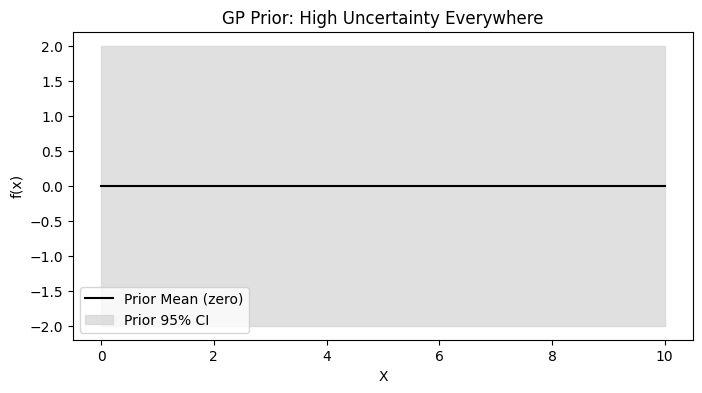

In [8]:
# Visualize GP Prior (no data)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

X_plot = np.linspace(0, 10, 100).reshape(-1, 1)
kernel = C(1.0) * RBF(length_scale=1.0)
gpr_prior = GaussianProcessRegressor(kernel=kernel, alpha=1e-10)

# Predict with no data: mean is zero, std is kernel variance
y_prior_mean, y_prior_std = gpr_prior.predict(X_plot, return_std=True)

plt.figure(figsize=(8,4))
plt.plot(X_plot, np.zeros_like(X_plot), label='Prior Mean (zero)', color='black')
plt.fill_between(X_plot.squeeze(), -2*y_prior_std, 2*y_prior_std, color='lightgray', alpha=0.7, label='Prior 95% CI')
plt.title('GP Prior: High Uncertainty Everywhere')
plt.xlabel('X')
plt.ylabel('f(x)')
plt.legend()
plt.show()

### 2. Posterior: After Seeing Data

Now we add a few data points. The GP posterior 'learns' from these, reducing uncertainty near them and bending the mean prediction toward the observed values.

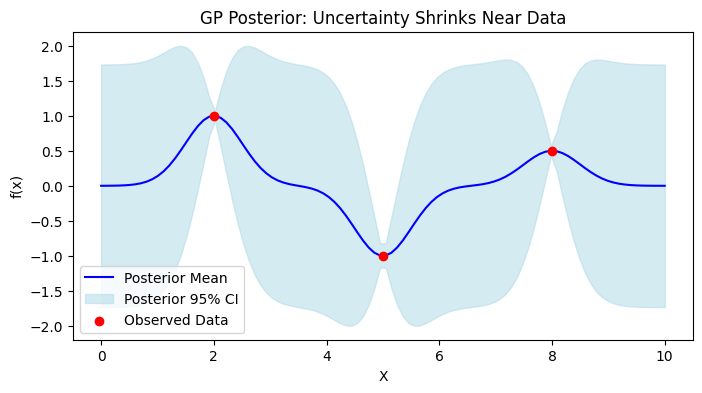

In [9]:
# Select a few data points
X_obs = np.array([[2], [5], [8]])
y_obs = np.array([1.0, -1.0, 0.5])

gpr_post = GaussianProcessRegressor(kernel=kernel, alpha=1e-10)
gpr_post.fit(X_obs, y_obs)
y_post_mean, y_post_std = gpr_post.predict(X_plot, return_std=True)

plt.figure(figsize=(8,4))
plt.plot(X_plot, y_post_mean, label='Posterior Mean', color='blue')
plt.fill_between(X_plot.squeeze(), y_post_mean - 2*y_post_std, y_post_mean + 2*y_post_std, color='lightblue', alpha=0.5, label='Posterior 95% CI')
plt.scatter(X_obs, y_obs, color='red', label='Observed Data', zorder=10)
plt.title('GP Posterior: Uncertainty Shrinks Near Data')
plt.xlabel('X')
plt.ylabel('f(x)')
plt.legend()
plt.show()

### Intuitive Takeaways

- **Prior:** High uncertainty everywhere, mean is zero.
- **Posterior:** Mean bends toward observed data, uncertainty shrinks near data and remains high far away.

GPR is like connecting the dots with a 'rubber band' that is tight near known points and loose elsewhere, honestly showing where it is unsure.

### 3. Sequential Learning: Posterior Becomes New Prior

When you add new data, the previous posterior acts as the new prior. GPR updates its beliefs, further reducing uncertainty and refining predictions near the new observations.

Let's add another data point and see how the GP adapts.

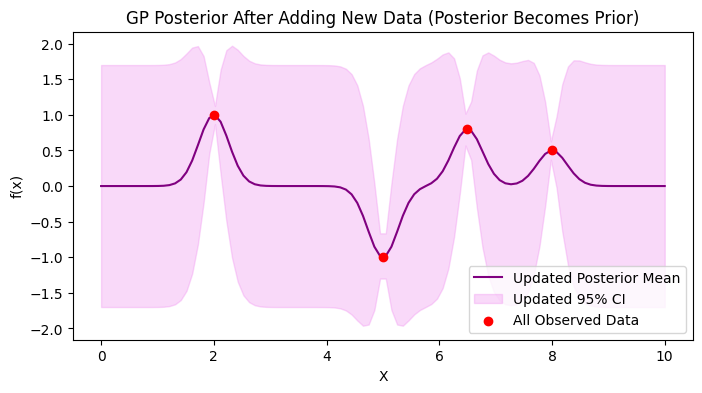

In [10]:
# Add a new observation and refit GP
X_obs2 = np.vstack([X_obs, [[6.5]]])
y_obs2 = np.append(y_obs, [0.8])

gpr_post2 = GaussianProcessRegressor(kernel=kernel, alpha=1e-10)
gpr_post2.fit(X_obs2, y_obs2)
y_post2_mean, y_post2_std = gpr_post2.predict(X_plot, return_std=True)

plt.figure(figsize=(8,4))
plt.plot(X_plot, y_post2_mean, label='Updated Posterior Mean', color='purple')
plt.fill_between(X_plot.squeeze(), y_post2_mean - 2*y_post2_std, y_post2_mean + 2*y_post2_std, color='violet', alpha=0.3, label='Updated 95% CI')
plt.scatter(X_obs2, y_obs2, color='red', label='All Observed Data', zorder=10)
plt.title('GP Posterior After Adding New Data (Posterior Becomes Prior)')
plt.xlabel('X')
plt.ylabel('f(x)')
plt.legend()
plt.show()

### Takeaway

Each time you add new data, the GP 'learns' more, updating its predictions and shrinking uncertainty near the new points. This sequential updating is a key feature of Bayesian methods like GPR.